<a href="https://colab.research.google.com/github/cfont03/Anomaly-breast-cancer-detection/blob/main/train/2.YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Data Upload

In [1]:
# Mount google drive
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Access and unzip images
!unzip "/content/gdrive/MyDrive/99_Output/all-mias.zip" -d "/"
print("DONE!")

In [3]:
# Importation of libraries
from tensorflow import keras 
print("Keras version   : ", keras.__version__)

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, ReLU)
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model
from tensorflow.keras import regularizers


%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

#from PIL import Image
import PIL.Image
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image
from keras.preprocessing import image as kp_image
#from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
#import tensorflow_addons as tfa

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns
from matplotlib import patches

from google.colab.patches import cv2_imshow
import time

Keras version   :  2.8.0
Populating the interactive namespace from numpy and matplotlib


In [4]:
# read csv file
df = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess.csv", sep = ";")
df.head()

,Unnamed: 0,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax
0,0,mdb001,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,535.0,599.0,197,/content/archive/all-mias/mdb001.pgm,338.0,732.0,402.0,796.0
1,1,mdb002,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,522.0,744.0,69,/content/archive/all-mias/mdb002.pgm,453.0,591.0,675.0,813.0
2,2,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,477.0,891.0,30,/content/archive/all-mias/mdb005.pgm,447.0,507.0,861.0,921.0
3,3,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,500.0,856.0,26,/content/archive/all-mias/mdb005.pgm,474.0,526.0,830.0,882.0
4,4,mdb010,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,525.0,599.0,33,/content/archive/all-mias/mdb010.pgm,492.0,558.0,566.0,632.0


In [5]:
# keep interesting fields
df_ = df.iloc[:, [8, 9, 10, 11, 12]]
df_['height'] = 1024
df_['weight'] = 1024
df_['cat'] = df['cat']
df_.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,image path,xmin,xmax,ymin,ymax,height,weight,cat
590,/content/archive/all-mias/mdb314_mask.pgm,479.000000,557.000000,794.00000,872.000000,1024,1024,MISC
591,/content/archive/all-mias/mdb315_hflip.jpeg,292.000000,686.000000,402.00000,796.000000,1024,1024,CIRC
592,/content/archive/all-mias/mdb315_noise.jpeg,423.000000,609.000000,484.00000,670.000000,1024,1024,CIRC
593,/content/archive/all-mias/mdb315_rotate.jpeg,712.818326,804.742207,797.67114,804.742207,1024,1024,CIRC
594,/content/archive/all-mias/mdb315_mask.pgm,423.000000,609.000000,484.00000,670.000000,1024,1024,CIRC


In [6]:
# show boundary box to image
def boundary_box (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  1: name image
  8: path image
  9: min coord x
  10: max coord x
  11: min coord y
  12: max coord y

  '''

  i = df.iloc[0]
  image = input("introduce image name: ") 
  im = cv2.imread('/content/archive/all-mias/{:}'.format(image))

  # generate x, y, width and height
  xmin, xmax, ymin, ymax = (i[9], i[10], i[11], i[12])
  width = xmax - xmin
  height = ymax - ymin

  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb012.pgm


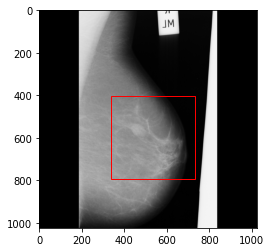

In [7]:
boundary_box(df)

# 1. YOLO

## 1.1. Obtain weights
https://www.youtube.com/watch?v=b59xfUZZqJE



In [8]:
! git clone https://github.com/iArunava/YOLOv3-Object-Detection-with-OpenCV # clone yolov3 github to obtain weights

Cloning into 'YOLOv3-Object-Detection-with-OpenCV'...
remote: Enumerating objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.


In [9]:
! cat "/content/gdrive/MyDrive/yolo_utils.py"

In [10]:
import sys
sys.path.append('/content/gdrive/MyDrive')

In [11]:
import yolo_utils

In [12]:
! wget https://pjreddie.com/media/files/yolov3.weights # obtain weights

--2022-03-27 19:17:56--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.0MB/s    in 11s     

2022-03-27 19:18:08 (21.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [13]:
yolo = cv2.dnn.readNet("/content/YOLOv3-Object-Detection-with-OpenCV/yolov3-coco/yolov3.cfg", "/content/yolov3.weights")

In [14]:
classes = df.iloc[:,4].unique().tolist() # take possible classes

# save classes in file
with open('classes.txt', 'w') as f:
    for item in classes:
        f.write("%s\n" % item)

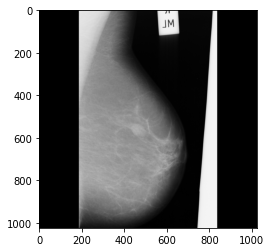

In [15]:
df[df['name'] == 'mdb012']
im = cv2.imread('/content/archive/all-mias/mdb012.pgm')
plt.imshow(im)

In [16]:
df.head(10)

,Unnamed: 0,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax
0,0,mdb001,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,535.0,599.0,197,/content/archive/all-mias/mdb001.pgm,338.0,732.0,402.0,796.0
1,1,mdb002,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,522.0,744.0,69,/content/archive/all-mias/mdb002.pgm,453.0,591.0,675.0,813.0
2,2,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,477.0,891.0,30,/content/archive/all-mias/mdb005.pgm,447.0,507.0,861.0,921.0
3,3,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,500.0,856.0,26,/content/archive/all-mias/mdb005.pgm,474.0,526.0,830.0,882.0
4,4,mdb010,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,525.0,599.0,33,/content/archive/all-mias/mdb010.pgm,492.0,558.0,566.0,632.0
5,5,mdb012,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,471.0,566.0,40,/content/archive/all-mias/mdb012.pgm,431.0,511.0,526.0,606.0
6,6,mdb013,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",MISC,667.0,659.0,31,/content/archive/all-mias/mdb013.pgm,636.0,698.0,628.0,690.0
7,7,mdb015,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,595.0,160.0,68,/content/archive/all-mias/mdb015.pgm,527.0,663.0,92.0,228.0
8,8,mdb017,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,547.0,451.0,48,/content/archive/all-mias/mdb017.pgm,499.0,595.0,403.0,499.0
9,9,mdb019,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,653.0,547.0,49,/content/archive/all-mias/mdb019.pgm,604.0,702.0,498.0,596.0


## 1.2. Implement model

In [93]:
def yolo(df, path_cfg, path_weights, w = 416, h = 416, threshold = 0.5):

  '''

  This function implements yolo pre-trained model.

  Requirements: downloaded .cfg and .weights files. To obtain these, plese see: https://pjreddie.com/darknet/yolo/

  Params: 
  - df with at least the following attribute:
    8: image path

  - patch_cfg: path with the configuration file from yolo pretrained model
  - path_weights: path with the weights from yolo pretrained model
  

  - w: width of resized image. Default 416
  - h: height of resized image. Default 416

  Images are in gray scale ==> channel = 1

  '''

  # show execution time
  start_time = time.time()

  # change channels in .cfg file to 1
  file = open(path_cfg, "r")
  replacement = ""
  for line in file:
    line = line.strip()
    changes = line.replace("channels=3", "channels=3") # replace line
    replacement = replacement + changes + "\n"

  file.close()

  fout = open(path_cfg, "w")
  fout.write(replacement)
  fout.close()


  
  boxes_all = []
  confidence_all = []
  class_id_all = []

  
  for i in df.iloc:
    img = cv2.imread(str(i[8]))
    #, cv2.IMREAD_GRAYSCALE) # gray scale images, channel = 1
    #img = cv2.resize(img, [32,32])
    height, width, shape = img.shape
    print(img.shape)
    blob = cv2.dnn.blobFromImage(img, 1/255, (w,h), (0,0,0), True, crop = False) # extract features. Normalize and resize. Swap RGB colours
    print(blob.shape)
    net = cv2.dnn.readNet(path_cfg, path_weights)
    layer_names = net.getLayerNames()
    outputlayers = [layer_names[z[0] - 1] for z in net.getUnconnectedOutLayers()]
    net.setInput(blob)
    outs = net.forward(outputlayers)
    
    boxes = []
    confidences = []
    class_ids = []

    for out in outs:
      for detection in out:
        score = detection[5:]
        class_id = np.argmax(score)
        confidence = score[class_id]
        confidences.append(float(confidence))
        class_ids.append(class_id)
        if confidence > threshold: ##### set up threshold
          # object detection
          centre_x = int(detection[0] * width)
          centre_y = int(detection[1] * height)
          w = int(detection[2] * width)
          h = int(detection[3] * height)

          # rectangle coordinates
          x = int(centre_x - w/2)
          y = int(centre_y - h/2)

          xmin = x
          xmax = x + w
          ymin = y
          ymax = y + h

          boxes.append([xmin,xmax,ymin,ymax])

          
    
    boxes_all.append(boxes)
    confidence_all.append(confidences)
    class_id_all.append(class_ids)


  # add values to df
  df['boxes'] = boxes_all
  df['confidence'] = confidence_all
  df['class_id'] = class_id_all

  print("--- %s seconds ---" % (time.time() - start_time))

  return df


In [96]:
df1 = df.iloc[0:5]
path_cfg = "/content/YOLOv3-Object-Detection-with-OpenCV/yolov3-coco/yolov3.cfg"
path_weights = "/content/yolov3.weights"


yolo(df1, path_cfg, path_weights, 416, 416, 0.5) # implement to our database

(1024, 1024, 3)
(1, 3, 416, 416)
(1024, 1024, 3)
(1, 3, 416, 416)
(1024, 1024, 3)
(1, 3, 416, 416)
(1024, 1024, 3)
(1, 3, 416, 416)
(1024, 1024, 3)
(1, 3, 416, 416)
--- 7.066180944442749 seconds ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,Unnamed: 0,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax,boxes,confidence,class_id
0,0,mdb001,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,535.0,599.0,197,/content/archive/all-mias/mdb001.pgm,338.0,732.0,402.0,796.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,mdb002,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,522.0,744.0,69,/content/archive/all-mias/mdb002.pgm,453.0,591.0,675.0,813.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,477.0,891.0,30,/content/archive/all-mias/mdb005.pgm,447.0,507.0,861.0,921.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,500.0,856.0,26,/content/archive/all-mias/mdb005.pgm,474.0,526.0,830.0,882.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,mdb010,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,525.0,599.0,33,/content/archive/all-mias/mdb010.pgm,492.0,558.0,566.0,632.0,"[[267, 717, 61, 902]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [99]:
def plot_boundary_box(df):
  
  '''

  The function plots a selected image with its predicted boundary box.
  
  Params:
  df with the following attributes:
  8: image path
  13: boundary box pred

  '''


  image = input("introduce image name: ")
  path = '/content/archive/all-mias/{:}'.format(image)
  img = cv2.imread(path)
  #img = cv2.resize(img, None, fx = 0.4, fy = 0.4)

  box = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,13]
  box = box.values[0]
  if (len(box) > 0):
    xmin = int(box[0][0])
    xmax = int(box[0][1])
    ymin = int(box[0][2])
    ymax = int(box[0][3])

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255,0), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  else:
    
    print("\nERROR: The selected image does not have any boundary box for yolov3 pre-trained model.")


introduce image name: mdb010.pgm


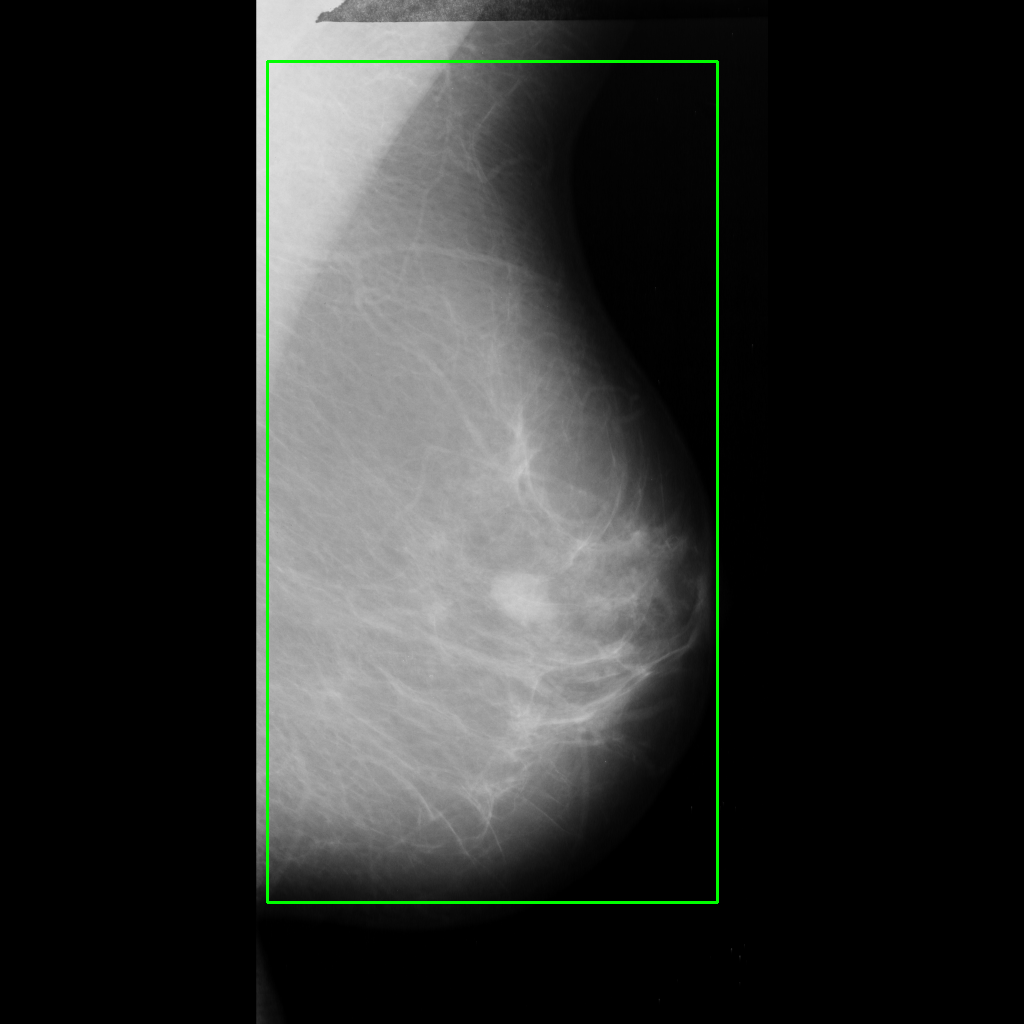

In [100]:
plot_boundary_box(df1)

In [ ]:
# source: https://www.youtube.com/watch?v=h56M5iUVgGs

## 1.3. Intersection over Union (IoU)

In [101]:
df1.head()

,Unnamed: 0,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax,boxes,confidence,class_id
0,0,mdb001,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,535.0,599.0,197,/content/archive/all-mias/mdb001.pgm,338.0,732.0,402.0,796.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,mdb002,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,522.0,744.0,69,/content/archive/all-mias/mdb002.pgm,453.0,591.0,675.0,813.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,477.0,891.0,30,/content/archive/all-mias/mdb005.pgm,447.0,507.0,861.0,921.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,500.0,856.0,26,/content/archive/all-mias/mdb005.pgm,474.0,526.0,830.0,882.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,mdb010,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,525.0,599.0,33,/content/archive/all-mias/mdb010.pgm,492.0,558.0,566.0,632.0,"[[267, 717, 61, 902]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [102]:
def IoU_yolo(df):
    
    '''

    Calculate Intersection of Union (IoU) between predicted box and ground truth.

    Params: df containing info on images
    1: name of the image
    4: label
    8: image path
    9: x min coord - ground truth
    10: x max coord - ground truth
    11: y min coord - ground truth
    12: y max coord - ground truth
    13: anchor: predicted box in array. Sorted by xmin, xmax, ymin, ymax
    
    '''
    
    
    # -----add an extra column with the ground truth in np.array----

    gts = []
    for i in df.iloc:
      xmin = i[9]
      xmax = i[10]
      ymin = i[11]
      ymax = i[12]

      gt = np.array([xmin, xmax, ymin, ymax])
      gts.append(gt)
    
    df['ground truth'] = gts



    # ------calculate coordinate of overlapping region------

    area_overlaps = []
    ious = []

    truth = df.iloc[:,16]
    pred = df.iloc[:,13]

    for truth, pred in zip(truth, pred):
      if(len(pred) > 0): ## check if there are any predicted values
        # take max of x1 and y1 out of both boxes
        x1 = max(truth[0], pred[0][0])
        y1 = max(truth[2], pred[0][2])
        # take min of x2 and y2 out of both boxes
        x2 = min(truth[1], pred[0][1])
        y2 = min(truth[3], pred[0][3])
        
        # ------area of overlapping region------
        width_overlap = abs(x2 - x1)
        height_overlap = abs(y2 - y1)
        area_overlap = width_overlap * height_overlap
        area_overlaps.append(area_overlap)      

      
        # ------computing union------
        # sum of area of both the boxes - area_overlap
        
        # height and width of both boxes
        width_truth = (truth[1] - truth[0])
        height_truth = (truth[3] - truth[2])
        
        width_pred = (pred[0][1] - pred[0][0])
        height_pred = (pred[0][3] - pred[0][2])
        
        # area of box1 and box2
        area_truth = width_truth * height_truth
        area_pred = width_pred * height_pred
        
        # union (including 2 * overlap area (double count))
        area_union_overlap = area_truth + area_pred

        # union
        area_union = area_union_overlap - area_overlap

        # compute IOU
        iou = area_overlap / area_union
        ious.append(iou)

      else:
        area_overlap = 0
        area_overlaps.append(area_overlap)
        iou = 0
        ious.append(iou)


    df['area_overlap'] = area_overlaps
    df['iou'] = ious
    
    return df

In [103]:
IoU_yolo(df1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Unnamed: 0,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax,boxes,confidence,class_id,ground truth,area_overlap,iou
0,0,mdb001,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,535.0,599.0,197,/content/archive/all-mias/mdb001.pgm,338.0,732.0,402.0,796.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[338.0, 732.0, 402.0, 796.0]",0.0,0.00000
1,1,mdb002,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,522.0,744.0,69,/content/archive/all-mias/mdb002.pgm,453.0,591.0,675.0,813.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[453.0, 591.0, 675.0, 813.0]",0.0,0.00000
2,2,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,477.0,891.0,30,/content/archive/all-mias/mdb005.pgm,447.0,507.0,861.0,921.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[447.0, 507.0, 861.0, 921.0]",0.0,0.00000
3,3,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,500.0,856.0,26,/content/archive/all-mias/mdb005.pgm,474.0,526.0,830.0,882.0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[474.0, 526.0, 830.0, 882.0]",0.0,0.00000
4,4,mdb010,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,525.0,599.0,33,/content/archive/all-mias/mdb010.pgm,492.0,558.0,566.0,632.0,"[[267, 717, 61, 902]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[492.0, 558.0, 566.0, 632.0]",4356.0,0.01151


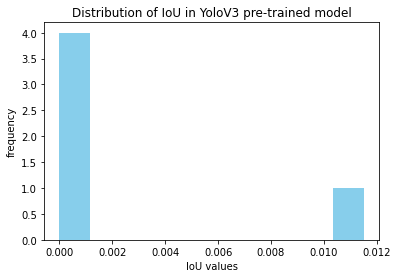

In [104]:
# plot frequency of IoU images

plt.hist(df1['iou'], color = 'skyblue')
plt.title('Distribution of IoU in YoloV3 pre-trained model')
plt.xlabel('IoU values')
plt.ylabel('frequency')
plt.show()

In [ ]:
# check how many images have a IoU > threshold

threshold = 0.5
df1[df1['iou'] > threshold].count()

## 1.4. Mean Average Precision (mAP)

In [ ]:
#img = cv2.imread("/content/20210925_225221_178_3600..jpg")
img = cv2.imread("/content/archive/all-mias/mdb290.pgm", cv2.IMREAD_GRAYSCALE)
#img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
print(img.shape)
blob = cv2.dnn.blobFromImage(img, 1/255, (320,320), (0,0,0), crop = False)
#i = blob[0].reshape(320,320,3)
plt.imshow(img)

In [ ]:
yolo.setInput(blob)

In [ ]:
output_layers_name = yolo.getUnconnectedOutLayersNames()
layer_output = yolo.forward(output_layers_name)

In [ ]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
indexes

In [ ]:
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size = (len(boxes),3))
#colors = [[255, 0, 0]]

In [ ]:
print(colors)

In [ ]:
if len(indexes) > 0:
  for i in indexes.flatten():
    x,y,w,h = boxes[i]
    #label = str(classes[class_ids[i]])
    conf = str(round(confidences[i],2))
    color = colors[i]

    cv2.rectangle(img, (x,y), (x+w,y+h), color, 4)
    #cv2.putText(img, label +" " + conf, (x,y+20), font, 2, (255,255,255), 2)

    plt.imshow(img)

In [ ]:
for z in df_.iloc:
  indexes = z[11]
  #print(indexes)
  if len(indexes) > 0:
    for i in indexes.flatten():
      x,y,w,h = boxes[i]
      label = str(classes[class_ids[i]])
      conf = str(round(confidences[i],2))
      color = colors[i]

      cv2.rectangle(img, (x,y), (x+w,y+h), color, 4)
      cv2.putText(img, label +" " + conf, (x,y+20), font, 2, (255,255,255), 2)
      #print(z[0])
      img = cv2.imread(z[0])
      plt.imshow(img)